In [ ]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, StaleElementReferenceException
import time
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import requests
from bs4 import BeautifulSoup
from PIL import Image
import base64
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
def get_stock(S_table):
    '''This function scrapes the data from the Nasdaq website and returns a pandas dataframe with the data.
    Send in the parametars the table you want to scrape. The options are:
    nextFiscalQ : Next Fiscal Quarter
    nextFiscalY : Next Fiscal Year
    currentQ : Current FiscalQuarter
    currentY : Current Fiscal Year
    '''
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument("--disable-notifications")
    browser = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
    browser.get("https://www.nasdaq.com/market-activity/analyst-forecast-change")

    
    try:
        accept_button = WebDriverWait(browser, 10).until(EC.element_to_be_clickable((By.XPATH, "//button[contains(text(),'I Accept')]")))
        accept_button.click()
    except TimeoutException:
        print("Accept button not found or unable to click")
    try:
        WebDriverWait(browser, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, f"button.table-tabs__tab[data-value='{S_table}']"))).click()
    except:
        pass
    
    data = []
    last_page_button = WebDriverWait(browser, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "button.pagination__page:last-child"))
        )
    total_pages = int(last_page_button.get_attribute('data-page'))
    
    for i in range(1, total_pages+1):
        try:
            
            print(f"Processing page {i}")
            
        
            try:
                accept_button = WebDriverWait(browser, 10).until(EC.element_to_be_clickable((By.XPATH, "//button[contains(text(),'I Accept')]")))
                accept_button.click()
            except TimeoutException:
                print("Accept button not found or unable to click")

            
            page_number = f".pagination__page[data-page='{i}']"
            element = WebDriverWait(browser, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, page_number)))
            element.click()
            time.sleep(3)
        except TimeoutException:
            print(f"Timeout while waiting for page {i} to load")
            continue  

        
        
        
        rows = browser.find_elements(By.XPATH, "//table[@class='analyst-forecast-change__table']//tbody//tr")
        if i%3 == 0:
            time.sleep(random.randint(2, 5))
        for row in rows:
            try:
                cells = row.find_elements(By.XPATH, ".//td")
                row_data = [cell.text for cell in cells]
                data.append(row_data)
            except StaleElementReferenceException:
                print("Stale Element Exception occurred while processing row. Trying to re-locate the elements.")
                rows = browser.find_elements(By.XPATH, "//table[@class='analyst-forecast-change__table']//tbody//tr")
                break

    num_columns = len(data[0])

    column_names = [
        "Symbol", 
        "Name", 
        "Market", 
        "Current", 
        "1 Week Ago", 
        "% Change", 
        "Total", 
        "Up", 
        "Down"
    ]
    df = pd.DataFrame(data, columns=column_names)




    browser.quit()
    return df

def get_log(company_symbol):
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    about_url = f"https://www.nasdaq.com/market-activity/stocks/{company_symbol}/dividend-history"
    driver.get(about_url)
    time.sleep (3)
    try:
        accept_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//button[contains(text(),'I Accept')]")))
        accept_button.click()
    except TimeoutException:
        print("Accept button not found or unable to click")
    time.sleep (3)
    html_content = driver.page_source
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    
    soup = BeautifulSoup(html_content, 'html.parser')

    rows = soup.find_all('tr', class_='dividend-history__row--data')

    data = []

    for row in rows:
        cells = row.find_all(['th', 'td'])
        row_data = [cell.get_text(strip=True) for cell in cells]
        data.append(row_data)

    column_names = [
    "Ex/EFF Date", 
    "Type", 
    "Cash Amount", 
    "Declaration Date", 
    "Record Date", 
    "Payment Date"
]

    df_log = pd.DataFrame(data, columns=column_names)
    return df_log

def get_recommendation(company_symbol):
    options = webdriver.ChromeOptions()
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

    driver.get(f"https://www.nasdaq.com/market-activity/stocks/{company_symbol}/analyst-research")

    try:
        WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, "//button[contains(text(),'I Accept')]"))
        ).click()
    except TimeoutException:
        print("No 'I Accept' button found or not clickable.")

    try:
        data_xpath = "/html/body/div[2]/div/main/div[2]/div[4]/div[3]/div/div[1]/div/div[2]/div[2]/div[2]/p"
        
        element_present = WebDriverWait(driver, 20).until(
            EC.presence_of_element_located((By.XPATH, data_xpath))
        )

        driver.execute_script("arguments[0].scrollIntoView(true);", element_present)
        time.sleep(2)  
        data_element = driver.find_element(By.XPATH, data_xpath)
        
        data_text = data_element.text

    except TimeoutException:
        print("Timed out waiting for the data to be present.")
        data_text = ""

    driver.quit()

    return data_text
def get_graph(company_symbol):
    options = webdriver.ChromeOptions()
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    driver.get(f"https://www.nasdaq.com/market-activity/stocks/{company_symbol}/analyst-research")
    try:
        WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, "//button[contains(text(),'I Accept')]"))
        ).click()
    except TimeoutException:
        print("No 'I Accept' button found or not clickable.")

    element = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, ".analyst-target-price__chart-container"))
    )
    driver.execute_script("arguments[0].scrollIntoView();", element)

    time.sleep(2)
    element.screenshot('graph.png')  

    driver.quit()
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    image_path = 'graph.png'
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off') 
    plt.show()
def get_photos():
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    about_url = f"https://www.nasdaq.com/solutions/listings/list-your-company"
    driver.get(about_url)
    time.sleep(3)
    try:
        accept_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//button[contains(text(),'I Accept')]")))
        accept_button.click()
    except TimeoutException:
        print("Accept button not found or unable to click")
    time.sleep(3)
    html_content = driver.page_source
    soup = BeautifulSoup(html_content, 'html.parser')

    image_tags = soup.select('.nsdq-l-grid__item img')

    image_tags = image_tags[:10]

    images = []

    if not os.path.exists('Events'):
        os.makedirs('Events')

    for i, img_tag in enumerate(image_tags):
        src = "https://www.nasdaq.com" + img_tag['src']
        if src.startswith('data:image'):
            base64_data = src.split(',')[1]
            img_data = base64.b64decode(base64_data)
            img = Image.open(BytesIO(img_data))
        else:
            driver.get(src)
            img = Image.open(BytesIO(driver.get_screenshot_as_png()))

        images.append(img)
        img_path = f'Events/image_{i}.png'
        img.save(img_path)
        plt.imshow(img)
        plt.show()

    print("Images saved in the 'Events' directory.")
    driver.quit()


In [ ]:
nextFiscalQ=get_stock('nextFiscalQ')

Processing page 1
Accept button not found or unable to click
Processing page 2
Accept button not found or unable to click
Processing page 3
Accept button not found or unable to click
Processing page 4
Accept button not found or unable to click
Processing page 5
Accept button not found or unable to click
Processing page 6
Accept button not found or unable to click
Processing page 7
Accept button not found or unable to click
Processing page 8
Accept button not found or unable to click
Processing page 9
Accept button not found or unable to click
Processing page 10
Accept button not found or unable to click
Processing page 11
Accept button not found or unable to click
Processing page 12
Accept button not found or unable to click
Processing page 13
Accept button not found or unable to click
Processing page 14
Accept button not found or unable to click
Processing page 15
Accept button not found or unable to click
Processing page 16
Accept button not found or unable to click


In [ ]:
nextFiscalQ

,Symbol,Name,Market,Current,1 Week Ago,% Change,Total,Up,Down
0,AIG,"American International Group, Inc.",NYSE,1.79,1.78,1%,6,1,0
1,ALL,Allstate Corporation (The),NYSE,1.66,1.65,1%,8,1,1
2,ALNY,"Alnylam Pharmaceuticals, Inc.",NASDAQ -GS,-1.17,-1.18,1%,10,1,0
3,AMP,"AMERIPRISE FINANCIAL SERVICES, LLC",NYSE,8.49,8.41,1%,6,3,0
4,ARI,Apollo Commercial Real Estate Finance,NYSE,0.35,0.34,1%,2,1,0
5,ASB,Associated Banc-Corp,NYSE,0.53,0.52,1%,4,1,0
6,BEN,"Franklin Resources, Inc.",NYSE,0.62,0.61,1%,5,2,0
7,BMY,Bristol-Myers Squibb Company,NYSE,1.78,1.75,1%,9,1,2
8,BXMT,"Capital Trust, Inc.",NYSE,0.52,0.51,1%,2,1,0
9,CCL,Carnival Corporation,NYSE,1.1,1.08,1%,7,1,0


In [ ]:
help(get_stock)

Help on function get_stock in module __main__:

get_stock(S_table)
    This function scrapes the data from the Nasdaq website and returns a pandas dataframe with the data.
    Send in the parametars the table you want to scrape. The options are:
    nextFiscalQ : Next Fiscal Quarter
    nextFiscalY : Next Fiscal Year
    currentQ : Current FiscalQuarter
    currentY : Current Fiscal Year



In [ ]:
get_log('AGNC')

,Ex/EFF Date,Type,Cash Amount,Declaration Date,Record Date,Payment Date
0,04/29/2024,Cash,$0.12,04/10/2024,04/30/2024,05/09/2024
1,03/27/2024,Cash,$0.12,03/13/2024,03/29/2024,04/09/2024
2,02/28/2024,Cash,$0.12,02/08/2024,02/29/2024,03/11/2024
3,01/30/2024,Cash,$0.12,01/10/2024,01/31/2024,02/09/2024
4,12/28/2023,Cash,$0.12,12/13/2023,12/29/2023,01/10/2024
5,11/29/2023,Cash,$0.12,11/08/2023,11/30/2023,12/11/2023
6,10/30/2023,Cash,$0.12,10/11/2023,10/31/2023,11/09/2023
7,09/28/2023,Cash,$0.12,09/13/2023,09/29/2023,10/11/2023
8,08/30/2023,Cash,$0.12,08/09/2023,08/31/2023,09/12/2023
9,07/28/2023,Cash,$0.12,07/12/2023,07/31/2023,08/09/2023


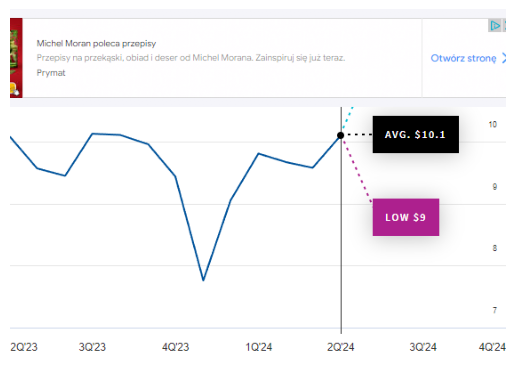

In [ ]:
get_graph('AGNC')

In [ ]:
get_recommendation('AGNC')

'Based on analysts offering 12 month price targets for AGNC in the last 3 months. The average price target is $10.1 with a high estimate of $10.75 and a low estimate of $9. Sign in to your SmartPortfolio to see more analyst recommendations.'

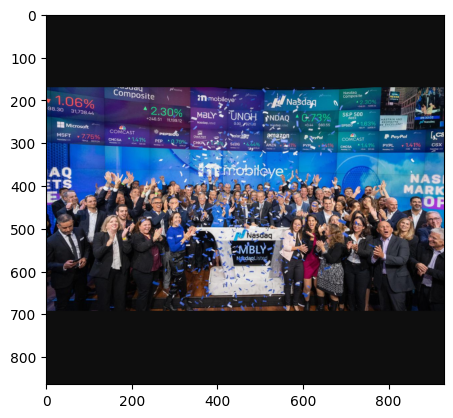

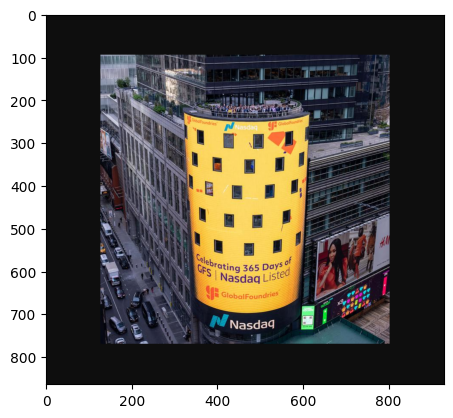

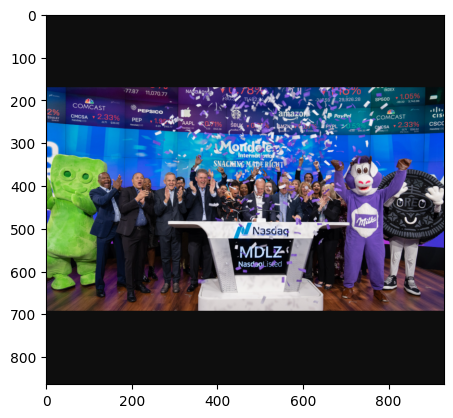

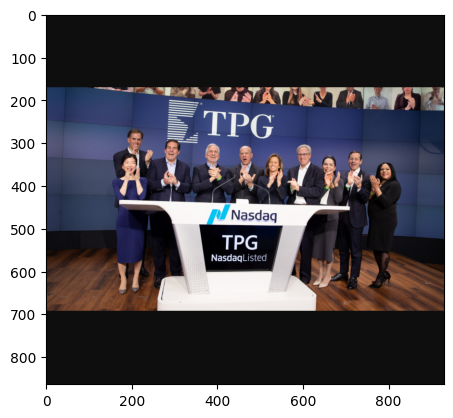

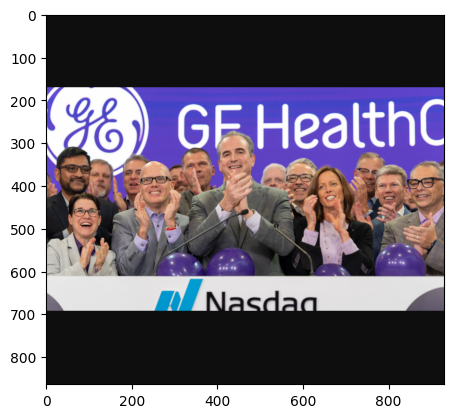

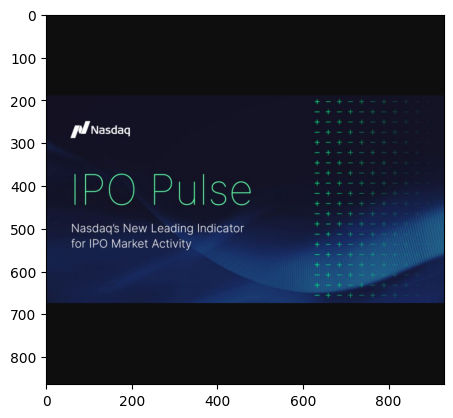

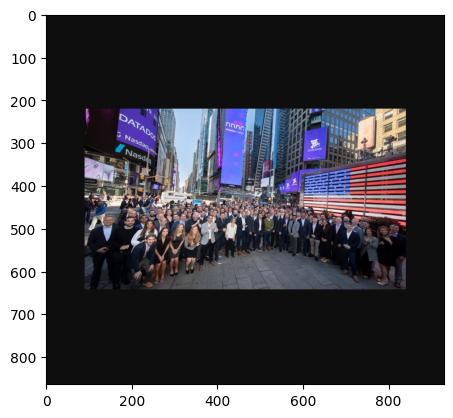

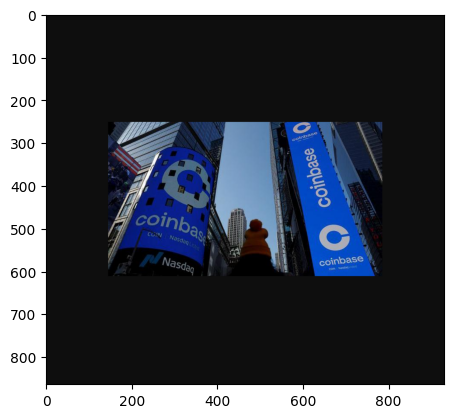

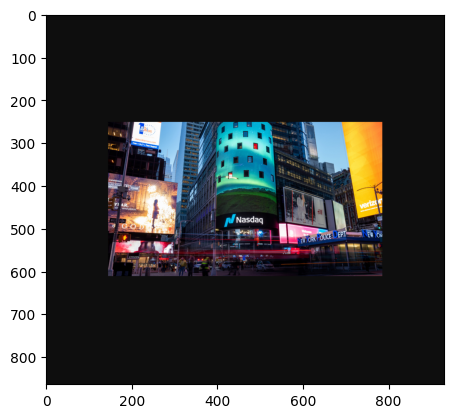

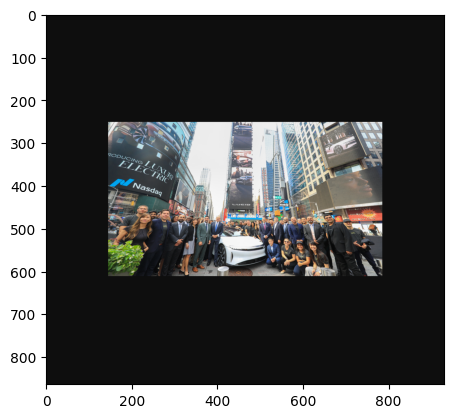

Images saved in the 'Events' directory.


In [ ]:
get_photos()